# Trotterization with light-cone ordering (short-time)

In [1]:
from qiskit.quantum_info import SparsePauliOp, random_statevector
from functools import partial
import multiprocessing

import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd
import scipy, jax

import matplotlib.pyplot as plt
import numpy as np

from utils import *
from spin_ham import *
from trotter import *
from bounds import *

figs_dir, data_dir = './figs', './data'

## Nearest-neighbor Heisenberg model

In [2]:
prefix, suffix = 'NNH', 'n'  # 'TFI', 'n'
use_jax = True
n_bnd_max = 100 # 400,  100,  200,  250
n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84]
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 199, 249]
r_max = n_bnd_max
n_max, n_min = 10, 5  #  9, 5 ;  12, 5 
J, h = 1, 0.3 # 1, 1 ;  0.2, 0.2 ;  1, 0.2
t, eps = 0.2, 0.005

In [3]:
field_list = [random.gauss(0, 0.1) for _ in range(n_bnd_max)]
# print('random field: ', field_list)
n_list_emp = np.arange(n_min, n_max+1)
print('n_list_emp: ', n_list_emp)

data_keys = ['worst', 'singl', 'multi', 'n']
bnd_data = dict([(k, []) for k in data_keys])
emp_data = dict([(k, []) for k in data_keys])
bnd_data['n'], emp_data['n'] = n_list_bnd, n_list_emp

r_start_worst_bnd, r_start_singl_bnd, r_start_multi_bnd, r_end = 1, 1, 1, r_max-1

for i, n in enumerate(n_list_bnd):
    hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, rand_field=field_list)
    # r_start, r_end = 1, int(n/2)
    print(f'-------------- n (bound) = {n} --------------')
    bnd_worst_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='worst_loose_bound', coeffs=['singl', n, hnn])
    # bnd_worst_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='worst_loose_bound', coeffs=['singl', n, cmm_data])
    # bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, tail_cmm_data])
    bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, hnn])
    bnd_multi_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['multi_zz', n, hnn])

    r_worst_bnd = binary_search_r(r_start_worst_bnd, r_end, eps, bnd_worst_err_r, comment='worst_bnd',verbose=True)
    r_singl_bnd = binary_search_r(r_start_singl_bnd, r_end, eps, bnd_singl_err_r, comment='singl_bnd',verbose=True)
    r_multi_bnd = binary_search_r(r_start_multi_bnd, r_end, eps, bnd_multi_err_r, comment='multi_bnd',verbose=True)
    bnd_data['worst'].append(r_worst_bnd)
    bnd_data['singl'].append(r_singl_bnd)
    bnd_data['multi'].append(r_multi_bnd)
    r_start_worst_bnd, r_start_singl_bnd, r_start_multi_bnd = r_worst_bnd, r_singl_bnd, r_multi_bnd

r_start_worst_emp, r_start_singl_emp, r_start_multi_emp, r_end = 1, 1, 1, r_max-1
for n in n_list_emp:
    print(f'-------------- n (empirical) = {n} --------------')
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=0, Jz=0, hx=0, hy=0, hz=h, pbc=False, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, rand_field=field_list)
    # field_list = hnn.rand_field
    singl_ob = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([('Z', [i], 1/n) for i in range(0, n)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([('Y', [i], 1) for i in range(0, n)], n).to_matrix()
    multi_ob = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1) for i in range(0, n-1)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([(random.choice(['X','Y','Z']), [i], 1) for i in range(0, n)], n).to_matrix()
    print('multi ob norm: ', np.linalg.norm(multi_ob, ord=2))
    multi_ob = multi_ob / np.linalg.norm(multi_ob, ord=2)
    par_group = [h.to_matrix() for h in hnn.ham_par]
    # par_group = [h.to_matrix() for h in hnn.ham_par][::-1]
    xyz_group = [h.to_matrix() for h in hnn.ham_xyz]

    exact_U = jax.scipy.linalg.expm(-1j * t * sum([h for h in par_group]))
    # verfiy the exact_U
    assert np.allclose(exact_U, jax.scipy.linalg.expm(-1j * t * sum([h for h in xyz_group])))

    emp_worst_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, type='worst_empirical', use_jax=use_jax)
    emp_singl_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=singl_ob, type='worst_ob_empirical', use_jax=use_jax)
    emp_multi_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=multi_ob, type='worst_ob_empirical', use_jax=use_jax)

    r_worst_emp = binary_search_r(r_start_worst_emp, r_end, eps, emp_worst_err_r, comment='worst_emp', verbose=True)
    r_singl_emp = binary_search_r(r_start_singl_emp, r_end, eps, emp_singl_err_r, comment='singl_emp',verbose=True)
    r_multi_emp = binary_search_r(r_start_multi_emp, r_end, eps, emp_multi_err_r, comment='multi_emp',verbose=True)
    emp_data['worst'].append(r_worst_emp)
    emp_data['singl'].append(r_singl_emp)
    emp_data['multi'].append(r_multi_emp)
    r_start_worst_emp, r_start_singl_emp, r_start_multi_emp = r_worst_emp, r_singl_emp, r_multi_emp

print('emp_data: ', emp_data)
# print(pd.DataFrame(emp_data))
# save to csv
pd.DataFrame(emp_data).to_csv(f'{data_dir}/{prefix}_emp_lightcone_max={n_max}_bnd_max={n_bnd_max}_{suffix}.csv', index=False)
pd.DataFrame(bnd_data).to_csv(f'{data_dir}/{prefix}_bnd_lightcone_max={n_max}_bnd_max={n_bnd_max}_{suffix}.csv', index=False)
pd.DataFrame(bnd_data)

n_list_emp:  [ 5  6  7  8  9 10]
-------------- n (bound) = 5 --------------
----[worst_bnd] binary search r (r_start=1, r_end=99)----
r_start: 1 ; r_end: 50
r_start: 1 ; r_end: 25
r_start: 1 ; r_end: 13
r_start: 7 ; r_end: 13
r_start: 10 ; r_end: 13
r_start: 10 ; r_end: 11
r: 11 ; err:  0.0046229359337832876
----[singl_bnd] binary search r (r_start=1, r_end=99)----
r_start: 1 ; r_end: 50
r_start: 1 ; r_end: 25
r_start: 1 ; r_end: 13
r_start: 1 ; r_end: 7
r_start: 4 ; r_end: 7
r_start: 4 ; r_end: 5
r: 5 ; err:  0.0043875840384912405
----[multi_bnd] binary search r (r_start=1, r_end=99)----
r_start: 1 ; r_end: 50
r_start: 1 ; r_end: 25
r_start: 1 ; r_end: 13
r_start: 1 ; r_end: 7
r_start: 4 ; r_end: 7
r_start: 4 ; r_end: 5
r: 5 ; err:  0.004387584038491241
-------------- n (bound) = 6 --------------
----[worst_bnd] binary search r (r_start=11, r_end=99)----
r_start: 11 ; r_end: 55
r_start: 11 ; r_end: 33
r_start: 11 ; r_end: 22
r_start: 11 ; r_end: 16
r_start: 11 ; r_end: 13
r_start: 12

,worst,singl,multi,n
0,11,5,5,5
1,13,6,6,6
2,15,6,6,7
3,16,7,7,8
4,17,7,7,9
5,19,7,7,10
6,21,8,8,12
7,24,9,9,15
8,26,9,9,18
9,30,10,10,23


    worst  singl  multi   n
0      11      5      5   5
1      13      6      6   6
2      15      6      6   7
3      16      7      7   8
4      17      7      7   9
5      19      7      7  10
6      21      8      8  12
7      24      9      9  15
8      26      9      9  18
9      30     10     10  23
10     34     10     11  29
11     39     10     12  36
12     43     10     12  44
13     48     10     13  55
14     54     10     13  68
15     60     10     13  84
a_em: 1.5609229264556446; b_em: 3.7115472182578118
a_em: -1.9517652530650724e-08; b_em: 6.756932463490179
a_em: 1.2005837783518218; b_em: 3.8000163863767726
a_em: 0.029279200331953414; b_em: 4.43461387428407
a_em: 0.9999999999999983; b_em: 3.4657359027997297


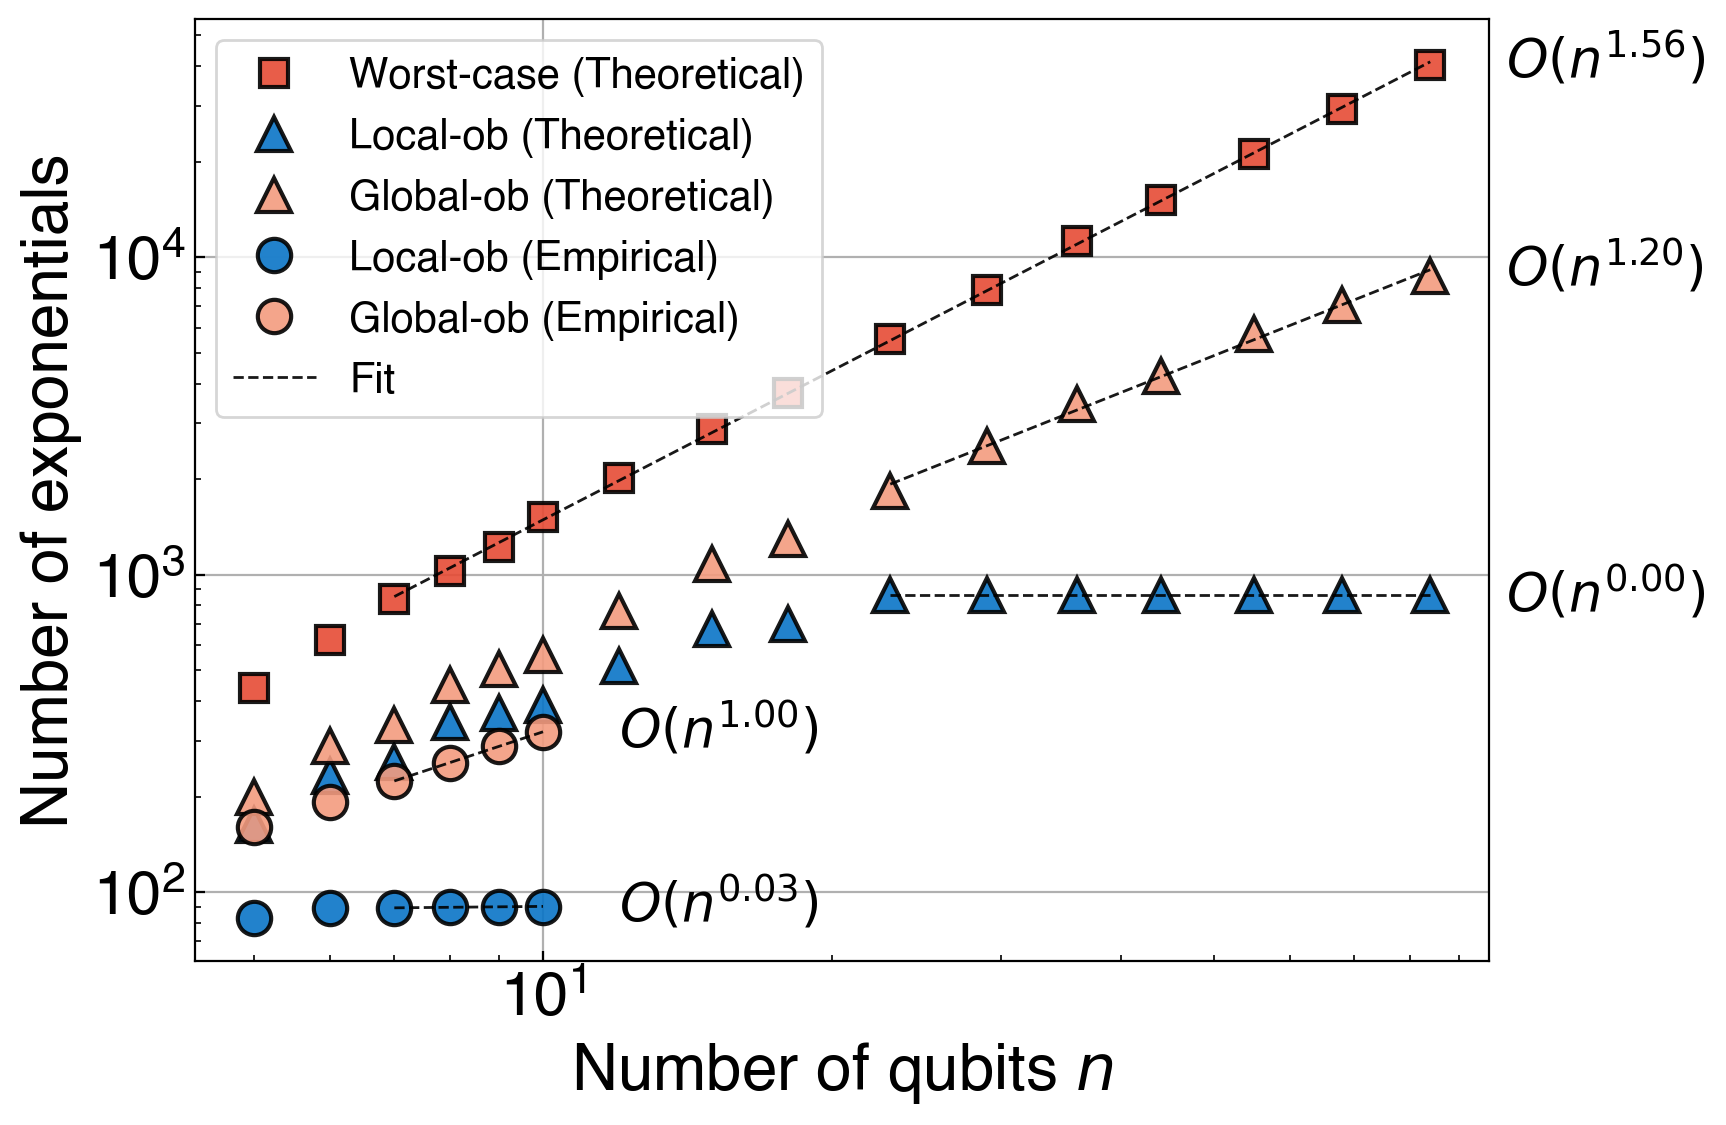

In [4]:
if prefix == 'TFI':
    factor = 2
elif prefix == 'NNH':
    factor = 4

emp_data = pd.read_csv(f'{data_dir}/{prefix}_emp_lightcone_max={n_max}_bnd_max={n_bnd_max}_{suffix}.csv')
bnd_data = pd.read_csv(f'{data_dir}/{prefix}_bnd_lightcone_max={n_max}_bnd_max={n_bnd_max}_{suffix}.csv')
print(bnd_data)

def exp_count_LC(r, n_qubits, n_terms):
    exp_count = 0
    for i in range(1, r+1):
        # print('i: ', i)
        if i < int(n_qubits/2):
            exp_count += (2*factor * i - 1) * 2    
            # exp_count += (4 * i - 1) * 2    
        elif i == int(n_qubits/2):
            exp_count += (2*factor * i - 1) * 2  - 1
        else:
            exp_count += n_terms * 2
    return exp_count

cost_st_list = [2 * factor*bnd_data['n'][i] * r for i, r in enumerate(bnd_data['worst'])]
cost_lc_list_s = [exp_count_LC(r, bnd_data['n'][i], factor*bnd_data['n'][i]) for i, r in enumerate(bnd_data['singl'])]
cost_lc_list_m = [2 * factor*bnd_data['n'][i] * r for i, r in enumerate(bnd_data['multi'])]
cost_em_list_s = [exp_count_LC(r, emp_data['n'][i], factor*emp_data['n'][i]) for i, r in enumerate(emp_data['singl'])]
cost_em_list_m =  [2 * factor*emp_data['n'][i] * r for i, r in enumerate(emp_data['multi'])]
cost_em_list_w =  [2 * factor*emp_data['n'][i] * r for i, r in enumerate(emp_data['worst'])]


plt.rc('axes', labelsize=LARGE_SIZE+3)  # fontsize of the x and y labels
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.markeredgewidth'] = 1.5
mpl.rcParams['lines.linewidth'] = 2.0

fig, ax2 = plt.subplots(figsize=(9, 6), layout='tight')
# ob_string = 'XIII'
ax2.plot(n_list_bnd, cost_st_list, 's', color='#E64B35FF', label=r'Worst-case (Theoretical)', markersize=10)
plot_fit(ax2, n_list_bnd[2:], cost_st_list[2:], var=suffix, x_offset=1.20, y_offset=0.9)
# # ax2.plot(n_list, cost_st_found_list, 's', label=r'Worst-case (Ref \textcolor{blue}{[13]})', markersize=10)
ax2.plot(n_list_bnd, cost_lc_list_s, '^', color='#0A75C7', label='Local-ob (Theoretical)', markersize=12)
plot_fit(ax2, n_list_bnd[-7:], cost_lc_list_s[-7:], var=suffix, x_offset=1.20, y_offset=0.9)
ax2.plot(n_list_bnd, cost_lc_list_m, '^', color='#F39B7FFF', label='Global-ob (Theoretical)', markersize=12)
plot_fit(ax2, n_list_bnd[-7:], cost_lc_list_m[-7:], var=suffix, x_offset=1.20, y_offset=0.9)
# plot_fit(ax2, n_list_bnd[2:9], cost_lc_list_m[2:9], var=suffix, x_offset=1.06, y_offset=0.8)
# ax2.plot(n_list_emp, cost_em_list_w, 'D', color='#E64B35FF', label=r'Worst-case (Empirical)', markersize=10)
ax2.plot(n_list_emp, cost_em_list_s, 'o', color='#0A75C7', label='Local-ob (Empirical)')
plot_fit(ax2, n_list_emp[-4:], cost_em_list_s[-4:], var=suffix, x_offset=1.20, y_offset=0.9)
ax2.plot(n_list_emp, cost_em_list_m, 'o', color='#F39B7FFF', label='Global-ob (Empirical)')
plot_fit(ax2, n_list_emp[-4:], cost_em_list_m[-4:], var=suffix, x_offset=1.20, y_offset=0.9, label='Fit')
# ax2.plot(n_list, r_lc_found_list, '-*', label='Lightcone (bound)', markeredgecolor='k')
# Add labels and a legend
ax2.set_xlabel(f'Number of qubits $n$')
ax2.set_ylabel('Number of exponentials')
# ax2.set_title(fr'{prefix} Heisenberg (J={J}, h={h}, fix t={t}, $\epsilon$={eps}) PF2')  
ax2.loglog(); ax2.grid(); ax2.legend(loc='upper left')
# fig.savefig(f'{figs_dir}/lightcone_NNH1d_J={J}_h={h}_n={n_list_emp[-1]}_eps={eps}_t={t}_2r.pdf', bbox_inches='tight')